# DB에서 results를 읽어서 그래프 그리기

<p>won@aimmo.co.kr(swhors@naver.com)</p>

- 주의 사항
  - DB 파일이 잠기면 "sudo fuser -k metrics.db"를 실행하여 주십시요.

In [2]:
!pip install pillow

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


In [1]:
def restart_kernel():
    # Restart the kernet after libraries are loaded.
    import IPython
    from datetime import datetime
    print(f'restart kernel... {datetime.now()}')
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

restart_kernel()

restart kernel... 2025-05-30 18:16:05.001779


In [6]:
import os
import sys
from datetime import datetime
cwd = os.getcwd()
sys.path.append(cwd)
print(sys.path)

print(f'load_library step#1 {datetime.now()}')

['/home/swhors/jupyter-workspace/LSTM/$PWD', '/home/swhors/jupyter-workspace/finance', '/home/swhors/jupyter-workspace/finance/venv/lib/python3.11/site-paches', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/home/swhors/jupyter-workspace/finance/venv/lib/python3.11/site-packages', '/home/swhors/jupyter-workspace/LSTM']
load_library step#1 2025-06-05 16:03:18.540783


In [7]:
from datetime import datetime
from lib.metrics_loader import load_data_by_version
from lib.graph_util import draw_data_graph
from lib.graph_util import draw_data_graph_v2
from lib.graph_util import load_image
from lib.graph_util import draw_graph_with_metric
from lib.graph_util import load_all_image
from lib.db_operate import init_results, conn_db, close_db, drop_table
print(f'load_library step#2 {datetime.now()}')

load_library step#2 2025-06-05 16:03:20.470308


In [8]:
!echo $PYTHONPATH

$PWD:/home/swhors/jupyter-workspace/finance:/home/swhors/jupyter-workspace/finance/venv/lib/python3.11/site-paches


In [9]:
from contextlib import closing


def read_csv(file_name, verbose=False):
    """ read_csv """
    import csv
    results = []
    f = open(file_name, 'r', encoding='utf-8')
    rdf = csv.reader(f)
    cnt = 0
    for line in rdf:
        if cnt == 0:
            columns = line
            if verbose:
                print(f'columns = {columns}')
        else:
            round = int(line[0])
            result = [int(i) for i in line[1:]]
            if verbose:
                print(f'round={round}, result={result}')
            results.append((round, result))
        cnt += 1
    f.close()
    return results


def row_to_result(row):
    """ row_to_result """
    if len(row) != 3:
        return (None, None)
    return row[1], [int(i) for i in row[2].split(",")]


def insert_result(conn, round, result, verbose=False):
    """ insert_result """
    query = "INSERT INTO results (round, metric) values(?, ?)"
    if verbose:
        print(f"query={query}")
        print(f"value={round},{result}")
    with closing(conn.cursor()) as cursor:
        cursor.execute(query, (round, ",".join([str(i) for i in result])))
    conn.commit()


def insert_single(round, result):
    """ insert_single """
    with closing(conn_db('./db/metrics.db')) as conn:
        insert_result(conn=conn, round=round, result=result)
        conn.commit()


def select_result(conn, round=-1, limit=0, is_asc=True, verbose=False):
    """ select_result """
    query = "SELECT * FROM results"
    query = query + ("" if round == -1 else f" where round={round}")
    query = query + ("" if limit == 0 else f" limit {limit}")
    query = query + (" order by round asc" if is_asc else " order by round desc")
    with closing(conn.cursor()) as cursor:
        cursor.execute(query)
        rows = cursor.fetchall()
        results = []
        for row in rows:
            round, result = row_to_result(row)
            if round is not None:
                results.append((round, result))
            if verbose:
                print(f'{type(row)}, {row}')
    return results


def delete_result(conn, round=-1, verbose=False):
    """ delete_result """
    query = "DELETE FROM results"
    query = query + ("" if round == -1 else f" where round={round}")
    with closing(conn.cursor()) as cursor:
        cursor.execute(query)
    conn.commit()


def load_data(verbose=False):
    """ load_data """
    conn = None
    with closing(conn_db('./db/metrics.db')) as conn:
        init_results(conn=conn)
        results_csv = read_csv('selectd3.csv', verbose=False)
        for result in results_csv:
            insert_result(conn, *result, verbose=False)


def get_results(verbose=False):
    """ get_results """
    conn = None
    with closing(conn_db('./db/metrics.db')) as conn:
        results_db = select_result(conn=conn)
        if verbose:
            for result in results_db:
                print(f'result = {result}')
        return results_db


def full_code_test():
    """ full_code_test """
    with closing(conn_db('metrics.db')) as conn:
        init_results(conn=conn)
        results_csv = read_csv('./csv/selectd3.csv', verbose=False)
        for result in results_csv:
            insert_result(conn, *result, verbose=False)
        results_db = select_result(conn=conn)
        for result in results_db:
            print(f'result = {result}')
        delete_result(conn=conn)
        drop_table(conn=conn, table_name="results")


In [10]:
def result_list_mapping(results):
    """ result_list_mapping """
    rounds = []
    result_by_trial = [[],[],[],[],[],[]]
    for result in results:
        pos = 0
        for num in result[1]:
            result_by_trial[pos].append(num)
            pos += 1
        rounds.append(result[0])
    return rounds, result_by_trial


def get_sums_of_metrics(results):
    """ get_sums_of_metrics """
    sums = []
    rounds = []
    for result in results:
        rounds.append(result[0])
        sums.append(sum(result[1]))
    return rounds, sums


In [11]:
# insert single new result
insert_data=False
if insert_data:
    insert_single(round=1172, result=[7, 9, 24, 40, 42, 44])

In [12]:
# load data if wanted

loaded_data = True
print(f'loaded_data step#1 {datetime.now()}')
if loaded_data == False:
    print(f'loaded_data step#2 {datetime.now()}')
    load_data()


loaded_data step#1 2025-06-05 16:03:40.175945


In [13]:
# full code test
want_to_test = False
print(f'full code test step#1 {datetime.now()}')
if want_to_test:
    print(f'full code test step#2 {datetime.now()}')
    code_test()

full code test step#1 2025-06-05 16:03:42.026565


In [15]:
results = get_results()
rounds, result_by_trial = result_list_mapping(results)
print(f'Now : {datetime.now()}')

Now : 2025-06-05 16:04:05.348647


from_pos=500, to_pos=574, depth=200
Now : 2025-06-05 16:04:16.224105


/home/swhors/jupyter-workspace/LSTM/lib/graph_util.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0)


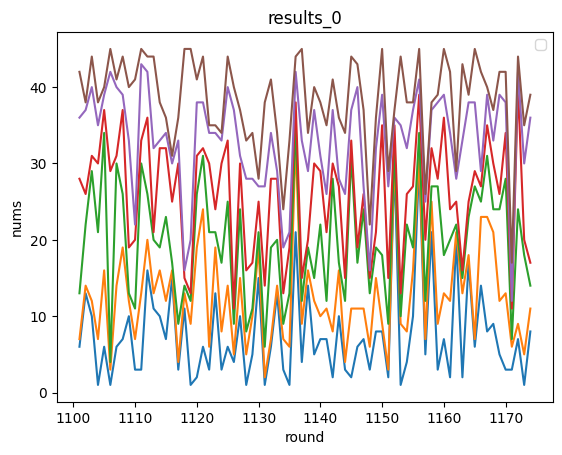

<Figure size 1500x500 with 0 Axes>

In [16]:
from lib.graph_util import draw_data_graph_v2
depth = 200
from_pos = 500
to_pos = len(rounds) if len(rounds) < (from_pos + depth) else (from_pos + depth)
print(f'from_pos={from_pos}, to_pos={to_pos}, depth={depth}')
colors = []
x_data = rounds[from_pos:to_pos]
y_datas = []
print(f'Now : {datetime.now()}')
for y in result_by_trial:
    y_datas.append(y[from_pos:to_pos])
draw_data_graph_v2(title="results_0",
                   version=999,
                   x_data=x_data,
                   y_datas=y_datas,
                   x_label="round",
                   y_label="nums",
                   colors=colors,
                   height=5,
                   width=15,
                   show_label=False
                  )

from_pos=500, to_pos=574, depth=200


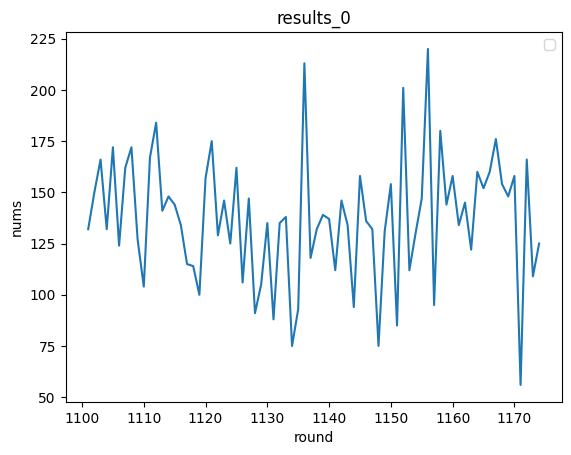

<Figure size 1500x500 with 0 Axes>

In [17]:
rounds, sums = get_sums_of_metrics(results=results)

from lib.graph_util import draw_data_graph_v2
sum_depth = 200
sum_from_pos = 500
sum_to_pos = len(rounds) if len(rounds) < (sum_from_pos + sum_depth) else (sum_from_pos + sum_depth)
print(f'from_pos={sum_from_pos}, to_pos={sum_to_pos}, depth={sum_depth}')

colors = []
x_data = rounds[sum_from_pos:sum_to_pos]
y_datas = [sums[sum_from_pos:sum_to_pos]]
draw_data_graph_v2(title="results_0",
                   version=999,
                   x_data=x_data,
                   y_datas=y_datas,
                   x_label="round",
                   y_label="nums",
                   colors=colors,
                   height=5,
                   width=15,
                   show_label=False
                  )

```
sqlite> select test_id, model_id, metric, matched from metrics where test_id='P4_5_1_1' and version=6 and round=40
 and model_id=14;
P4_5_1_1|14|4,9,15,26,38,44|
P4_5_1_1|14|9,13,27,35,37,40|35
P4_5_1_1|14|3,9,22,24,35,40|35
P4_5_1_1|14|4,9,17,21,30,33|30
P4_5_1_1|14|28,22,1,33,2,24|1
sqlite> select test_id, model_id, metric, matched from metrics where test_id='P4_5_1_1' and version=10 and round=8 and model_id=14;
P4_5_1_1|14|6,20,21,34,35,40|20,35
P4_5_1_1|14|9,13,16,24,32,43|
P4_5_1_1|14|33,8,9,17,22,44|
P4_5_1_1|14|4,16,28,31,32,33|
P4_5_1_1|14|6,18,23,33,35,42|18,35
sqlite> select test_id, model_id, metric, matched from metrics where test_id='P4_5_1_1' and version=3 and round=1 
and model_id=44;
P4_5_1_1|44|5,9,11,23,32,39|5
P4_5_1_1|44|5,10,14,24,35,44|5,35
P4_5_1_1|44|1,29,32,33,38,42|1
P4_5_1_1|44|29,45,16,31,4,6|
P4_5_1_1|44|14,16,18,21,27,38|18
sqlite> select test_id, model_id, metric, matched from metrics where test_id='P4_5_1_1' and version=12 and round=3 and model_id=44;
P4_5_1_1|44|38,27,34,22,17,9|
P4_5_1_1|44|1,2,9,10,20,28|1,20
P4_5_1_1|44|1,3,9,15,24,36|1
P4_5_1_1|44|20,21,34,37,43,44|20
P4_5_1_1|44|38,2,6,36,26,37|
sqlite> select test_id, model_id, metric, matched from metrics where test_id='P4_5_1_1' and version=1 and round=31 and model_id=44;
P4_5_1_1|44|42,44,2,45,31,11|
P4_5_1_1|44|1,5,7,23,27,41|1,5
P4_5_1_1|44|12,19,24,25,36,40|
P4_5_1_1|44|6,8,22,23,24,44|
P4_5_1_1|44|9,17,23,25,32,35|35
```

In [18]:
new_ndata = [[
    [4,9,15,26,38,44],
    [9,13,27,35,37,40],
    [3,9,22,24,35,40],
    [4,9,17,21,30,33],
    [28,22,1,33,2,24]
    ],[
    [6,20,21,34,35,40],
    [9,13,16,24,32,43],
    [33,8,9,17,22,44],
    [4,16,28,31,32,33],
    [6,18,23,33,35,42]
    ],[
    [5,9,11,23,32,39],
    [5,10,14,24,35,44],
    [1,29,32,33,38,42],
    [29,45,16,31,4,6],
    [14,16,18,21,27,38]
    ],[
    [38,27,34,22,17,9],
    [1,2,9,10,20,28],
    [1,3,9,15,24,36],
    [20,21,34,37,43,44],
    [38,2,6,36,26,37]
    ],[
    [42,44,2,45,31,11],
    [1,5,7,23,27,41],
    [12,19,24,25,36,40],
    [6,8,22,23,24,44],
    [9,17,23,25,32,35]]
             ]
last = [[1, 5, 18, 20, 30, 35],
        [7, 9, 24, 40, 42, 44],
        [3, 6, 7, 11, 12, 17],
        [3, 13, 28, 34, 38, 42],
        [5, 12, 24, 29, 32, 42]]
print(f'\n\nSum')
for l in last:
    print(l, sum(l))

print(f'\n\nCandidate')

for datas in new_ndata:
    print(f'{"*"*20}')
    for m in datas:
        print(m, sum(m))



Sum
[1, 5, 18, 20, 30, 35] 109
[7, 9, 24, 40, 42, 44] 166
[3, 6, 7, 11, 12, 17] 56
[3, 13, 28, 34, 38, 42] 158
[5, 12, 24, 29, 32, 42] 144


Candidate
********************
[4, 9, 15, 26, 38, 44] 136
[9, 13, 27, 35, 37, 40] 161
[3, 9, 22, 24, 35, 40] 133
[4, 9, 17, 21, 30, 33] 114
[28, 22, 1, 33, 2, 24] 110
********************
[6, 20, 21, 34, 35, 40] 156
[9, 13, 16, 24, 32, 43] 137
[33, 8, 9, 17, 22, 44] 133
[4, 16, 28, 31, 32, 33] 144
[6, 18, 23, 33, 35, 42] 157
********************
[5, 9, 11, 23, 32, 39] 119
[5, 10, 14, 24, 35, 44] 132
[1, 29, 32, 33, 38, 42] 175
[29, 45, 16, 31, 4, 6] 131
[14, 16, 18, 21, 27, 38] 134
********************
[38, 27, 34, 22, 17, 9] 147
[1, 2, 9, 10, 20, 28] 70
[1, 3, 9, 15, 24, 36] 88
[20, 21, 34, 37, 43, 44] 199
[38, 2, 6, 36, 26, 37] 145
********************
[42, 44, 2, 45, 31, 11] 175
[1, 5, 7, 23, 27, 41] 104
[12, 19, 24, 25, 36, 40] 156
[6, 8, 22, 23, 24, 44] 127
[9, 17, 23, 25, 32, 35] 141


In [18]:
new_ndata = [[[8,19,24,25,37,45],
              [9,24,26,34,39,44],
              [1,8,11,20,34,41],
              [1,5,7,14,27,45],
              [4,13,27,42,43,44]],
             [[4,9,26,28,42,44],
              [17,22,23,33,40,43],
              [3,30,31,33,39,43],
              [3,6,27,38,39,44],
              [5,7,12,14,29,37]]]
last = [[8, 11, 14, 17, 36, 39],
        [1, 5, 18, 20, 30, 35],
        [7, 9, 24, 40, 42, 44],
        [3, 6, 7, 11, 12, 17],
        [3, 13, 28, 34, 38, 42],
        [5, 12, 24, 29, 32, 42]]
print(f'\n\nLast\'s Sum')
for l in last:
    print(l, sum(l))

print(f'\n\nCandidate')

for datas in new_ndata:
    print(f'{"*"*20}')
    for m in datas:
        print(m, sum(m))



Last's Sum
[8, 11, 14, 17, 36, 39] 125
[1, 5, 18, 20, 30, 35] 109
[7, 9, 24, 40, 42, 44] 166
[3, 6, 7, 11, 12, 17] 56
[3, 13, 28, 34, 38, 42] 158
[5, 12, 24, 29, 32, 42] 144


Candidate
********************
[8, 19, 24, 25, 37, 45] 158
[9, 24, 26, 34, 39, 44] 176
[1, 8, 11, 20, 34, 41] 115
[1, 5, 7, 14, 27, 45] 99
[4, 13, 27, 42, 43, 44] 173
********************
[4, 9, 26, 28, 42, 44] 153
[17, 22, 23, 33, 40, 43] 178
[3, 30, 31, 33, 39, 43] 179
[3, 6, 27, 38, 39, 44] 157
[5, 7, 12, 14, 29, 37] 104


``` 1175에상
  5 [ 8, 19, 24, 25, 37, 45] 158 [ 8]
 34 [ 9, 24, 26, 34, 39, 44] 176 [39]
 35 [ 1,  8, 11, 20, 34, 41] 115 [ 8,11]
 76 [ 1,  5,  7, 14, 27, 45] 99  [14]
 77 [ 4, 13, 27, 42, 43, 44] 173 []

  5 [ 4,  9, 26, 28, 42, 44] 153 []
 35 [17, 22, 23, 33, 40, 43] 178 [17]
612 [ 3, 30, 31, 33, 39, 43] 179 [39]
613 [ 3,  6, 27, 38, 39, 44] 157 [39]
614 [ 5,  7, 12, 14, 29, 37] 104 [14]
```